In [215]:
#Importing Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [216]:
#Importing data files
seeds = pd.read_csv('DataFiles/NCAATourneySeeds.csv')
tourney_results = pd.read_csv('DataFiles/NCAATourneyDetailedResults.csv')
regular_results = pd.read_csv('DataFiles/RegularSeasonDetailedResults.csv')
kenpom = pd.read_csv('DataFiles/KenPomData.csv', index_col = 0)
teams = pd.read_csv('DataFiles/TeamSpellings.csv', dtype = str, engine = 'python')
print(tourney_results.shape)
print(regular_results.shape)
print(kenpom.shape)
print(teams.shape)

(1048, 34)
(87504, 34)
(5830, 16)
(1154, 2)


Since the current dataframe has Winning Team ID and losing team ID, we will duplicate the data by swapping the order of teams in given tables:

In [217]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'         
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).sort_index().reset_index(drop=True)
    
    return output

In [218]:
tourney_results = prepare_data(tourney_results)
regular_results = prepare_data(regular_results)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [219]:
#Concatenating both tourney_results and regular_results into one dataframe
data = pd.concat([tourney_results, regular_results])
print(data.shape)
#print(data.dtypes)
data.columns

(177104, 34)


Index(['DayNum', 'NumOT', 'Season', 'T1_Ast', 'T1_Blk', 'T1_DR', 'T1_FGA',
       'T1_FGA3', 'T1_FGM', 'T1_FGM3', 'T1_FTA', 'T1_FTM', 'T1_OR', 'T1_PF',
       'T1_Score', 'T1_Stl', 'T1_TO', 'T1_TeamID', 'T2_Ast', 'T2_Blk', 'T2_DR',
       'T2_FGA', 'T2_FGA3', 'T2_FGM', 'T2_FGM3', 'T2_FTA', 'T2_FTM', 'T2_OR',
       'T2_PF', 'T2_Score', 'T2_Stl', 'T2_TO', 'T2_TeamID', 'location'],
      dtype='object')

In [220]:
data['T1_TeamID'] = data['T1_TeamID'].astype(str)
data['T2_TeamID'] = data['T2_TeamID'].astype(str)

# make it a binary task
data['win'] = np.where(data['T1_Score']>data['T2_Score'], 1, 0)

In [221]:
#Bringing in seeds
seeds = pd.read_csv('DataFiles/NCAATourneySeeds.csv')
seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds['TeamID'] = seeds['TeamID'].astype(str)
data = data.merge(seeds, how = 'left', left_on = ['Season', 'T1_TeamID'], right_on = ['Season', 'TeamID'] ).rename(columns = {'Seed': 'T1Seed'})
data = data.merge(seeds, how = 'left', left_on = ['Season', 'T2_TeamID'], right_on = ['Season', 'TeamID'] ).rename(columns = {'Seed': 'T2Seed'})
data.drop(['TeamID_x', 'TeamID_y'], axis = 1, inplace = True)
print(data['T1Seed'].isna().sum())
print(data['T2Seed'].isna().sum())
gc.collect()
#data.columns

139154
139154


103

In [222]:
#Checking kenpom data
#renaming columns
teams['TeamNameSpelling'] = teams['TeamNameSpelling'].str.replace(' ', '').str.lower().str.replace('-', '').str.lower()
kenpom.rename(columns= {'Year':'Season'
                        }, inplace = True)
kenpom['Teams'] = kenpom['Teams'].str.replace('\d+', '').str.replace(" ","").str.lower()

#Bringing in TeamID
kenpom = kenpom.merge(teams[['TeamID', 'TeamNameSpelling']], how = 'left', left_on = 'Teams', right_on='TeamNameSpelling')
kenpom.dropna(axis = 0, inplace = True)
kenpom = kenpom.groupby(['Season', 'TeamID']).first()
print(kenpom.shape)

(5829, 16)


In [223]:
#Bringing in Kenpom data 
data = data.merge(kenpom, how = 'left', left_on = ['Season', 'T1_TeamID'], right_on = ['Season', 'TeamID'])
data.drop(['Teams', 'WinLoss', 'TeamNameSpelling'], axis = 1, inplace = True)
data.rename(columns = {'Rank' : 'T1Rank',
                        'Conf' : 'T1Conf',
                        'AdjustedEM': 'T1AdjustedEM',
                        'AdOfE': 'T1AdOfE', 
                        'AdOfER': 'T1AdOfER', 
                        'AdDeE': 'T1AdDeE', 
                        'AdDeER': 'T1AdDeER', 
                        'AdTempo': 'T1AdTempo', 
                        'AdTempoR': 'T1AdTempoR', 
                        'Luck': 'T1Luck',
                        'LuckRank':'T1LuckRank', 
                        'AdSoS': 'T1AdSoS', 
                        'AdSoSR': 'T1AdSoSR'}, inplace = True)

data = data.merge(kenpom, how = 'left', left_on = ['Season', 'T2_TeamID'], right_on = ['Season', 'TeamID'])
data.drop(['Teams', 'WinLoss', 'TeamNameSpelling'], axis = 1, inplace = True)
data.rename(columns = {'Rank' : 'T2Rank',
                        'Conf' : 'T2Conf',
                        'AdjustedEM': 'T2AdjustedEM',
                        'AdOfE': 'T2AdOfE', 
                        'AdOfER': 'T2AdOfER', 
                        'AdDeE': 'T2AdDeE', 
                        'AdDeER': 'T2AdDeER', 
                        'AdTempo': 'T2AdTempo', 
                        'AdTempoR': 'T2AdTempoR', 
                        'Luck': 'T2Luck',
                        'LuckRank':'T2LuckRank', 
                        'AdSoS': 'T2AdSoS', 
                        'AdSoSR': 'T2AdSoSR'}, inplace = True)

['T1Seed', 'T2Seed', 'T1Rank', 'T1Conf', 'T1AdjustedEM', 'T1AdOfE', 'T1AdOfER', 'T1AdDeE', 'T1AdDeER', 'T1AdTempo', 'T1AdTempoR', 'T1Luck', 'T1LuckRank', 'T1AdSoS', 'T1AdSoSR', 'T2Rank', 'T2Conf', 'T2AdjustedEM', 'T2AdOfE', 'T2AdOfER', 'T2AdDeE', 'T2AdDeER', 'T2AdTempo', 'T2AdTempoR', 'T2Luck', 'T2LuckRank', 'T2AdSoS', 'T2AdSoSR']
139154
139154


/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2485., 2405., 2380., 2339., 2307., 2283., 2292., 2276., 2251.,
        2265., 2703., 2314., 2241., 2196., 2160., 3053.]),
 array([ 1.    ,  1.9375,  2.875 ,  3.8125,  4.75  ,  5.6875,  6.625 ,
         7.5625,  8.5   ,  9.4375, 10.375 , 11.3125, 12.25  , 13.1875,
        14.125 , 15.0625, 16.    ]),
 <a list of 16 Patch objects>)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


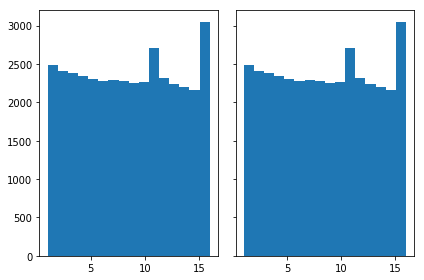

In [224]:
#Checking which columns have Nan Values
print(data.columns[data.isna().any()].tolist())
print(data['T1Seed'].isna().sum())
print(data['T2Seed'].isna().sum())
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(data['T1Seed'], bins = 16)
axs[1].hist(data['T2Seed'], bins = 16)


In [225]:
#Since we have a uniform distribution of seeds, we will replace missing values with mean
#Replacing those values with mean of the TeamID if it exists and with the mean of Seeds if it does not exits

data['T1Seed'] = data.groupby('T1_TeamID')['T1Seed'].transform(lambda x: x.fillna(x.mean()))
data['T1Rank'] = data.groupby('T1_TeamID')['T1Rank'].transform(lambda x: x.fillna(x.mean()))
data['T1AdjustedEM'] = data.groupby('T1_TeamID')['T1AdjustedEM'].transform(lambda x: x.fillna(x.mean()))
data['T1AdOfE'] = data.groupby('T1_TeamID')['T1AdOfE'].transform(lambda x: x.fillna(x.mean()))
data['T1AdOfER'] = data.groupby('T1_TeamID')['T1AdOfER'].transform(lambda x: x.fillna(x.mean()))
data['T1AdDeER'] = data.groupby('T1_TeamID')['T1AdDeER'].transform(lambda x: x.fillna(x.mean()))
data['T1AdDeE'] = data.groupby('T1_TeamID')['T1AdDeE'].transform(lambda x: x.fillna(x.mean()))
data['T1AdTempo'] = data.groupby('T1_TeamID')['T1AdTempo'].transform(lambda x: x.fillna(x.mean()))
data['T1AdTempoR'] = data.groupby('T1_TeamID')['T1AdTempoR'].transform(lambda x: x.fillna(x.mean()))
data['T1Luck'] = data.groupby('T1_TeamID')['T1Luck'].transform(lambda x: x.fillna(x.mean()))
data['T1LuckRank'] = data.groupby('T1_TeamID')['T1LuckRank'].transform(lambda x: x.fillna(x.mean()))
data['T1AdSoS'] = data.groupby('T1_TeamID')['T1AdSoS'].transform(lambda x: x.fillna(x.mean()))
data['T1AdSoSR'] = data.groupby('T1_TeamID')['T1AdSoSR'].transform(lambda x: x.fillna(x.mean()))


print(data['T1Seed'].isna().sum())
print(data['T1Rank'].isna().sum())
print(data['T1AdjustedEM'].isna().sum())
print(data['T1AdOfE'].isna().sum())
print(data['T1AdOfER'].isna().sum())
print(data['T1AdDeE'].isna().sum())
print(data['T1AdDeER'].isna().sum())
print(data['T1AdTempo'].isna().sum())
print(data['T1AdTempoR'].isna().sum())
print(data['T1Luck'].isna().sum())
print(data['T1LuckRank'].isna().sum())
print(data['T1AdSoS'].isna().sum())
print(data['T1AdSoSR'].isna().sum())

47973
0
0
0
0
0
0
0
0
0
0
0
0


In [226]:
#Since we have a uniform distribution of seeds, we will replace missing values with mean
#Replacing those values with mean of the TeamID if it exists and with the mean of Seeds if it does not exits

data['T2Seed'] = data.groupby('T2_TeamID')['T2Seed'].transform(lambda x: x.fillna(x.mean()))
data['T2Rank'] = data.groupby('T2_TeamID')['T2Rank'].transform(lambda x: x.fillna(x.mean()))
data['T2AdjustedEM'] = data.groupby('T2_TeamID')['T2AdjustedEM'].transform(lambda x: x.fillna(x.mean()))
data['T2AdOfE'] = data.groupby('T2_TeamID')['T2AdOfE'].transform(lambda x: x.fillna(x.mean()))
data['T2AdOfER'] = data.groupby('T2_TeamID')['T2AdOfER'].transform(lambda x: x.fillna(x.mean()))
data['T2AdDeER'] = data.groupby('T2_TeamID')['T2AdDeER'].transform(lambda x: x.fillna(x.mean()))
data['T2AdDeE'] = data.groupby('T2_TeamID')['T2AdDeE'].transform(lambda x: x.fillna(x.mean()))
data['T2AdTempo'] = data.groupby('T2_TeamID')['T2AdTempo'].transform(lambda x: x.fillna(x.mean()))
data['T2AdTempoR'] = data.groupby('T2_TeamID')['T2AdTempoR'].transform(lambda x: x.fillna(x.mean()))
data['T2Luck'] = data.groupby('T2_TeamID')['T2Luck'].transform(lambda x: x.fillna(x.mean()))
data['T2LuckRank'] = data.groupby('T2_TeamID')['T2LuckRank'].transform(lambda x: x.fillna(x.mean()))
data['T2AdSoS'] = data.groupby('T2_TeamID')['T2AdSoS'].transform(lambda x: x.fillna(x.mean()))
data['T2AdSoSR'] = data.groupby('T2_TeamID')['T2AdSoSR'].transform(lambda x: x.fillna(x.mean()))


print(data['T2Seed'].isna().sum())
print(data['T2Rank'].isna().sum())
print(data['T2AdjustedEM'].isna().sum())
print(data['T2AdOfE'].isna().sum())
print(data['T2AdOfER'].isna().sum())
print(data['T2AdDeE'].isna().sum())
print(data['T2AdDeER'].isna().sum())
print(data['T2AdTempo'].isna().sum())
print(data['T2AdTempoR'].isna().sum())
print(data['T2Luck'].isna().sum())
print(data['T2LuckRank'].isna().sum())
print(data['T2AdSoS'].isna().sum())
print(data['T2AdSoSR'].isna().sum())

47973
0
0
0
0
0
0
0
0
0
0
0
0


/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 2485.,  2469.,  3372.,  3425.,  6014.,  8872.,  7706.,  6797.,
         5886.,  5011.,  6164.,  7707., 13164., 12090., 17609., 20360.]),
 array([ 1.    ,  1.9375,  2.875 ,  3.8125,  4.75  ,  5.6875,  6.625 ,
         7.5625,  8.5   ,  9.4375, 10.375 , 11.3125, 12.25  , 13.1875,
        14.125 , 15.0625, 16.    ]),
 <a list of 16 Patch objects>)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


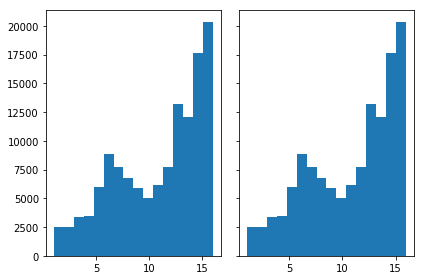

In [227]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(data['T1Seed'], bins = 16)
axs[1].hist(data['T2Seed'], bins = 16)

In [228]:
#For the rest of the missing values of Seeds, we will train a simple Randomforest regressor model to predict the seeds
#test data will be where T1seed or T2 seed is 0

#Imputing seeds for T1_TeamID

features = ['T1_Ast', 'T1_Blk', 'T1_FGA',
       'T1_FGA3', 'T1_FTA', 'T1_PF',
       'T1_Stl', 'T1_TO', 'T2_Ast', 'T2_Blk', 
       'T2_FGA', 'T2_FGA3', 'T2_FTA', 
       'T2_PF', 'T2_Stl', 'T2_TO']

train_data = data[data['T1Seed'].notna()]

test_data = data[data['T1Seed'].isna()]
test_data.drop(['T1Seed'], axis = 1, inplace = True)
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

regr.fit(train_data[features], train_data['T1Seed'])

test_data['T1Seed'] = regr.predict(test_data[features])                 

print("Regression imputation T1Seed complete")

/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Regression imputation T1Seed complete


/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [229]:
data = pd.concat([train_data, test_data])
print(data.shape)

(177104, 63)


/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [230]:
#Imputing Seed for T2_TeamID in a similar manner

train_data = data[data['T2Seed'].notna()]

test_data = data[data['T2Seed'].isna()]
test_data.drop(['T2Seed'], axis = 1, inplace = True)
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

regr.fit(train_data[features], train_data['T2Seed'])

test_data['T2Seed'] = regr.predict(test_data[features])  

print("Regression imputation T2Seed complete")
data = pd.concat([train_data, test_data])
print(data.shape)
gc.collect()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Regression imputation T2Seed complete
(177104, 63)


/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


0

(array([ 2485.,  2469.,  3372.,  3425.,  6014.,  8872.,  7721.,  6995.,
         7135., 10628., 24842., 26569., 16277., 12331., 17609., 20360.]),
 array([ 1.    ,  1.9375,  2.875 ,  3.8125,  4.75  ,  5.6875,  6.625 ,
         7.5625,  8.5   ,  9.4375, 10.375 , 11.3125, 12.25  , 13.1875,
        14.125 , 15.0625, 16.    ]),
 <a list of 16 Patch objects>)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


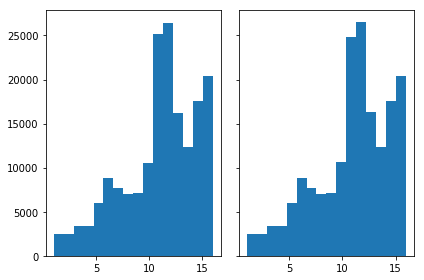

In [231]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(data['T1Seed'], bins = 16)
axs[1].hist(data['T2Seed'], bins = 16)

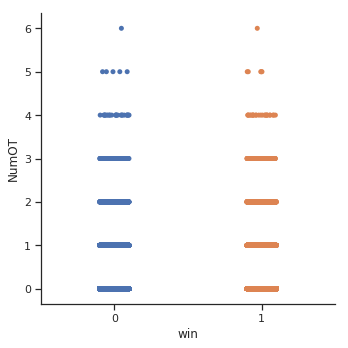

In [232]:
#Checking relationship between number of overtime with wins
sns.set(style="ticks", color_codes=True)
sns.catplot(x="win", y="NumOT", data = data);

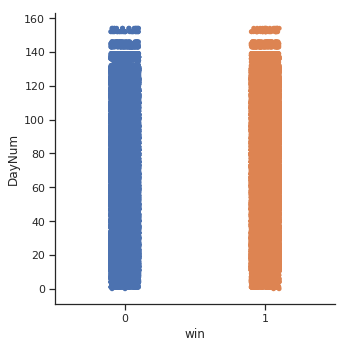

In [233]:
sns.set(style="ticks", color_codes=True)
sns.catplot(x="win", y="DayNum", data = data);

In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177104 entries, 0 to 176977
Data columns (total 63 columns):
DayNum          177104 non-null int64
NumOT           177104 non-null int64
Season          177104 non-null int64
T1AdDeE         177104 non-null float64
T1AdDeER        177104 non-null float64
T1AdOfE         177104 non-null float64
T1AdOfER        177104 non-null float64
T1AdSoS         177104 non-null float64
T1AdSoSR        177104 non-null float64
T1AdTempo       177104 non-null float64
T1AdTempoR      177104 non-null float64
T1AdjustedEM    177104 non-null float64
T1Conf          177019 non-null object
T1Luck          177104 non-null float64
T1LuckRank      177104 non-null float64
T1Rank          177104 non-null float64
T1Seed          177104 non-null float64
T1_Ast          177104 non-null int64
T1_Blk          177104 non-null int64
T1_DR           177104 non-null int64
T1_FGA          177104 non-null int64
T1_FGA3         177104 non-null int64
T1_FGM          177104 non

In [236]:
#Splitting data into train and validation
train_X = data[data['Season'] <= 2017]
val_X = data[data['Season'] > 2017]
train_y = train_X['win']
val_y = val_X['win']
train_X.drop(['win'], axis = 1, inplace = True)
val_X.drop(['win'], axis = 1, inplace = True)
print(train_X.shape)
print(val_X.shape)

(155234, 62)
(21870, 62)


/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [237]:
#Creating benchmark model with seeds and seed difference as features
benchmark_train_X = train_X[['T1Seed', 'T2Seed']]
benchmark_train_y = train_y
benchmark_train_X['diff'] = benchmark_train_X['T1Seed'] - benchmark_train_X['T1Seed']

benchmark_val_X = val_X[['T1Seed', 'T2Seed']]
benchmark_val_y = val_y
benchmark_val_X['diff'] = benchmark_val_X['T1Seed'] - benchmark_val_X['T1Seed']

/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [238]:
#Fitting the base logistic regression model
from sklearn.linear_model import LogisticRegression
base_model = LogisticRegression(dual = True, class_weight= 'balanced', max_iter = 100, random_state = 17)
base_model.fit(benchmark_train_X, benchmark_train_y)

benchmark_predictions = base_model.predict_proba(benchmark_val_X)
#Checking logloss score on trained model

from sklearn.metrics import log_loss, roc_auc_score
benchmark_logloss = log_loss(benchmark_val_y, benchmark_predictions)
benchmark_auc = roc_auc_score(benchmark_val_y, benchmark_predictions[:,1])
print("The benchmark logloss to beat is {}".format(benchmark_logloss))
print("The benchmark roc-auc to beat is {}".format(benchmark_auc))

del(train_X, val_X, benchmark_train_X, benchmark_train_y, benchmark_val_X, benchmark_val_y, train_y, val_y )

The benchmark logloss to beat is 0.6637146205272134
The benchmark roc-auc to beat is 0.6304704295595477


In [187]:
data.columns

Index(['DayNum', 'NumOT', 'Season', 'T1AdDeE', 'T1AdDeER', 'T1AdOfE',
       'T1AdOfER', 'T1AdSoS', 'T1AdSoSR', 'T1AdTempo', 'T1AdTempoR',
       'T1AdjustedEM', 'T1Conf', 'T1Luck', 'T1LuckRank', 'T1Rank', 'T1Seed',
       'T1_Ast', 'T1_Blk', 'T1_DR', 'T1_FGA', 'T1_FGA3', 'T1_FGM', 'T1_FGM3',
       'T1_FTA', 'T1_FTM', 'T1_OR', 'T1_PF', 'T1_Score', 'T1_Stl', 'T1_TO',
       'T1_TeamID', 'T2AdDeE', 'T2AdDeER', 'T2AdOfE', 'T2AdOfER', 'T2AdSoS',
       'T2AdSoSR', 'T2AdTempo', 'T2AdTempoR', 'T2AdjustedEM', 'T2Conf',
       'T2Luck', 'T2LuckRank', 'T2Rank', 'T2Seed', 'T2_Ast', 'T2_Blk', 'T2_DR',
       'T2_FGA', 'T2_FGA3', 'T2_FGM', 'T2_FGM3', 'T2_FTA', 'T2_FTM', 'T2_OR',
       'T2_PF', 'T2_Score', 'T2_Stl', 'T2_TO', 'T2_TeamID', 'location', 'win'],
      dtype='object')

In [239]:
#Now that we have our benchmark metric to beat let us engineer certain features based on nbastuffer analytics

def feauture_engineering(df, ID = 'T1', ID2 = 'T2'):
    features = ['Assist_Ratio', 'Turnover_Ratio', 'Possession', 'Offensive_Efficiency', 'Defensive_Efficiency',
               'Point_Differential', 'Efficiency_Differential', 'Defensive_Rebound_Perc', 'Offensive_Rebound_Perc',
               'Eff_Field_Goal_Perc', 'Turnover_Rate', 'Free_Throw_Rate', 'Four_Factor']
    features = [ID + '_' + str(feature) for feature in features]

    df[features[0]] = ((df.filter(regex = ID+".*Ast$").values*100)/(df.filter(regex = ID+'.*FGA$').values + \
                                                                    df.filter(regex = ID+'.*FTA$').values*0.44 + \
                                                                    df.filter(regex = ID+'.*Ast$').values + \
                                                                    df.filter(regex = ID+'.*TO$').values)).ravel()
    df[features[1]] = ((df.filter(regex = ID+".*TO$").values*100)/(df.filter(regex = ID+'.*FGA$').values + \
                                                                    df.filter(regex = ID+'.*FTA$').values*0.44 + \
                                                                    df.filter(regex = ID+'.*Ast$').values + \
                                                                    df.filter(regex = ID+'.*TO$').values)).ravel()
    df[features[2]] = (0.96*(df.filter(regex = ID+'.*FGA$').values + \
                                                                    df.filter(regex = ID+'.*FTA$').values*0.44 - \
                                                                    df.filter(regex = ID+'.*OR$').values + \
                                                                    df.filter(regex = ID+'.*TO$').values)).ravel()
    df[features[3]] = 100*(df.filter(regex = ID+'.*Score$').values).ravel()/df[features[2]]
    
    df[features[4]] = 100*(df.filter(regex = ID2 + '.*Score$').values).ravel()/df[features[2]]
    
    df[features[5]] = (df.filter(regex = ID+'.*Score$').values - df.filter(regex = ID2 + '.*Score$').values).ravel()
    
    df[features[6]] = df[features[3]] -  df[features[4]]
    
    df[features[7]] = (df.filter(regex = ID+'.*DR$').values/(df.filter(regex = ID+'.*DR$').values + \
                                                            df.filter(regex = ID2+'.*OR$').values)).ravel()
    
    df[features[8]] = (df.filter(regex = ID+'.*OR$').values/(df.filter(regex = ID+'.*OR$').values + \
                                                            df.filter(regex = ID2+'.*DR$').values)).ravel()
    
    df[features[9]] = ((df.filter(regex = ID+'.*FGM$').values + 0.5*df.filter(regex = ID+'.*FGM3$').values)/ \
                        df.filter(regex = ID+'.*FGA$').values).ravel()
    
    df[features[10]] = ((df.filter(regex = ID+".*TO$").values)/(df.filter(regex = ID+'.*FGA$').values + \
                                                                    df.filter(regex = ID+'.*FTA$').values*0.44 + \
                                                                    df.filter(regex = ID+'.*TO$').values)).ravel()
    df[features[11]] = (df.filter(regex = ID+".*FTM$").values/df.filter(regex = ID+".*FGA$").values).ravel()
    
    df[features[12]] = 0.4*df[features[9]] + 0.25* df[features[10]] + 0.2*df[features[8]] + 0.15*df[features[11]]
    return df

In [240]:
data = feauture_engineering(data, ID = 'T1', ID2= 'T2')
data = feauture_engineering(data, ID = 'T2', ID2= 'T1')
data['Seed_Diff'] = data['T1Seed'] - data['T2Seed']
data.head()

,DayNum,NumOT,Season,T1AdDeE,T1AdDeER,T1AdOfE,T1AdOfER,T1AdSoS,T1AdSoSR,T1AdTempo,...,T2_Defensive_Efficiency,T2_Point_Differential,T2_Efficiency_Differential,T2_Defensive_Rebound_Perc,T2_Offensive_Rebound_Perc,T2_Eff_Field_Goal_Perc,T2_Turnover_Rate,T2_Free_Throw_Rate,T2_Four_Factor,Seed_Diff
0,134,1,2003,113.5,319.0,101.2,187.0,-6.45,272.0,68.0,...,121.863344,-8,-10.596812,0.666667,0.361702,0.522388,0.156838,0.208955,0.351848,0.0
1,134,1,2003,108.7,281.0,98.3,238.0,-12.97,321.0,68.4,...,111.550229,8,10.623831,0.638298,0.333333,0.543478,0.129814,0.246377,0.353468,0.0
2,136,0,2003,99.5,114.0,101.1,191.0,-5.13,251.0,64.4,...,68.850441,29,39.150251,0.818182,0.297297,0.522727,0.181488,0.166667,0.338922,15.0
3,136,0,2003,88.8,8.0,115.6,10.0,8.69,31.0,72.7,...,109.533824,-29,-39.706011,0.702703,0.181818,0.343750,0.202188,0.109375,0.240817,-15.0
4,136,0,2003,97.4,78.0,113.9,18.0,8.74,30.0,66.9,...,124.572893,-13,-19.279138,0.687500,0.425532,0.413043,0.132979,0.202899,0.314003,3.0


In [243]:
import category_encoders as ce
encoder = ce.TargetEncoder()
encoder.fit(data[['T1Conf', 'T2Conf']], data['win'])
data[['T1Conf', 'T2Conf']] = encoder.transform(data[['T1Conf', 'T2Conf']])
print(data.shape)
print(data.columns)

(177104, 90)
Index(['DayNum', 'NumOT', 'Season', 'T1AdDeE', 'T1AdDeER', 'T1AdOfE',
       'T1AdOfER', 'T1AdSoS', 'T1AdSoSR', 'T1AdTempo', 'T1AdTempoR',
       'T1AdjustedEM', 'T1Conf', 'T1Luck', 'T1LuckRank', 'T1Rank', 'T1Seed',
       'T1_Ast', 'T1_Blk', 'T1_DR', 'T1_FGA', 'T1_FGA3', 'T1_FGM', 'T1_FGM3',
       'T1_FTA', 'T1_FTM', 'T1_OR', 'T1_PF', 'T1_Score', 'T1_Stl', 'T1_TO',
       'T1_TeamID', 'T2AdDeE', 'T2AdDeER', 'T2AdOfE', 'T2AdOfER', 'T2AdSoS',
       'T2AdSoSR', 'T2AdTempo', 'T2AdTempoR', 'T2AdjustedEM', 'T2Conf',
       'T2Luck', 'T2LuckRank', 'T2Rank', 'T2Seed', 'T2_Ast', 'T2_Blk', 'T2_DR',
       'T2_FGA', 'T2_FGA3', 'T2_FGM', 'T2_FGM3', 'T2_FTA', 'T2_FTM', 'T2_OR',
       'T2_PF', 'T2_Score', 'T2_Stl', 'T2_TO', 'T2_TeamID', 'location', 'win',
       'T1_Assist_Ratio', 'T1_Turnover_Ratio', 'T1_Possession',
       'T1_Offensive_Efficiency', 'T1_Defensive_Efficiency',
       'T1_Point_Differential', 'T1_Efficiency_Differential',
       'T1_Defensive_Rebound_Perc', 'T1_Offe

In [248]:
features = ['T1AdDeE', 'T1AdDeER', 'T1AdOfE',
       'T1AdOfER', 'T1AdSoS', 'T1AdSoSR', 'T1AdTempo', 'T1AdTempoR',
       'T1AdjustedEM', 'T1Conf', 'T1Luck', 'T1LuckRank', 'T1Rank', 'T1Seed',
       'T2AdDeE', 'T2AdDeER', 'T2AdOfE', 'T2AdOfER', 'T2AdSoS',
       'T2AdSoSR', 'T2AdTempo', 'T2AdTempoR', 'T2AdjustedEM', 'T2Conf',
       'T2Luck', 'T2LuckRank', 'T2Rank', 'T2Seed',
       'Seed_Diff']

### Lets check the performance of our models and compare it to benchmark results

In [249]:
#Using only Logistic Regression
#Using both Logistic Regression and Random Forest
seasons = [2016,2017,2018, 2019]

metric = []

for season in seasons:
    #Splitting data into train and validation
    train_X = data[data['Season'] != season]
    val_X = data[data['Season'] == season]
    train_y = train_X['win']
    val_y = val_X['win']
    train_X.drop(['win'], axis = 1, inplace = True)
    val_X.drop(['win'], axis = 1, inplace = True)
    print(train_X.shape)
    print(val_X.shape)
    
    train_X = train_X[features]
    val_X = val_X[features]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(train_X)
    
    train_X =  scaler.transform(train_X)
    val_X = scaler.transform(val_X)
    
    #Fitting the base logistic regression model
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    model = LogisticRegression(dual = True, class_weight= 'balanced', max_iter = 100, random_state = 17)
    model.fit(train_X, train_y)
    
    
    predictions = model.predict_proba(val_X)
   
    #Checking logloss score on trained model

    from sklearn.metrics import log_loss, roc_auc_score
    logloss = log_loss(val_y, predictions)
   
    
    auc = roc_auc_score(val_y, predictions[:,1])
    
    print("The logloss after feature engineering is {} for season {}".format(logloss, season))
    print("The roc-auc after feature engineering is {} for season {}".format(auc, season))
    metric.append(logloss)

print(f'The mean logloss across the seasons was {np.mean(metric)}')

/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(166232, 89)
(10872, 89)
The logloss after feature engineering is 0.4814452798850766 for season 2016
The roc-auc after feature engineering is 0.8470667912550944 for season 2016
(166180, 89)
(10924, 89)
The logloss after feature engineering is 0.4781961466906124 for season 2017
The roc-auc after feature engineering is 0.8489167392138836 for season 2017
(166160, 89)
(10944, 89)
The logloss after feature engineering is 0.48287924069551763 for season 2018
The roc-auc after feature engineering is 0.8447035185505796 for season 2018
(166178, 89)
(10926, 89)
The logloss after feature engineering is 0.4794829799191899 for season 2019
The roc-auc after feature engineering is 0.8472170076706933 for season 2019
The mean logloss across the seasons was 0.48050091179759913


In [250]:
#Using only Random Forest
seasons = [2016,2017,2018, 2019]

metric = []

for season in seasons:
    #Splitting data into train and validation
    train_X = data[data['Season'] != season]
    val_X = data[data['Season'] == season]
    train_y = train_X['win']
    val_y = val_X['win']
    train_X.drop(['win'], axis = 1, inplace = True)
    val_X.drop(['win'], axis = 1, inplace = True)
    print(train_X.shape)
    print(val_X.shape)
    
    train_X = train_X[features]
    val_X = val_X[features]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(train_X)
    
    train_X =  scaler.transform(train_X)
    val_X = scaler.transform(val_X)
    
    #Fitting the base logistic regression model
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators= 500, max_depth= 5)
    model.fit(train_X, train_y)
    
    predictions = model.predict_proba(val_X)

    #Checking logloss score on trained model

    from sklearn.metrics import log_loss, roc_auc_score
    logloss = log_loss(val_y, predictions)

    
    auc = roc_auc_score(val_y, predictions[:,1])

    print("The logloss after feature engineering is {} for season {}".format(logloss, season))
    print("The roc-auc after feature engineering is {} for season {}".format(auc, season))
    metric.append(logloss)

print(f'The mean logloss across the seasons was {np.mean(metric)}')

/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(166232, 89)
(10872, 89)
The logloss after feature engineering is 0.5104774130761209 for season 2016
The roc-auc after feature engineering is 0.8365990926053167 for season 2016
(166180, 89)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)



(10924, 89)
The logloss after feature engineering is 0.5121680961895544 for season 2017
The roc-auc after feature engineering is 0.8360130664096308 for season 2017


/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(166160, 89)
(10944, 89)
The logloss after feature engineering is 0.5143469225768648 for season 2018
The roc-auc after feature engineering is 0.8309687736450959 for season 2018
(166178, 89)
(10926, 89)


/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


The logloss after feature engineering is 0.5123453755784243 for season 2019
The roc-auc after feature engineering is 0.8358061113639227 for season 2019
The mean logloss across the seasons was 0.5123344518552411


In [251]:
#Using both logistic Regression and Random Forest
seasons = [2016,2017,2018, 2019]

metric = []

for season in seasons:
    #Splitting data into train and validation
    train_X = data[data['Season'] != season]
    val_X = data[data['Season'] == season]
    train_y = train_X['win']
    val_y = val_X['win']
    train_X.drop(['win'], axis = 1, inplace = True)
    val_X.drop(['win'], axis = 1, inplace = True)
    print(train_X.shape)
    print(val_X.shape)
    
    train_X = train_X[features]
    val_X = val_X[features]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(train_X)
    
    train_X =  scaler.transform(train_X)
    val_X = scaler.transform(val_X)
    
    #Fitting the base logistic regression model
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    
    model = LogisticRegression(dual = True, class_weight= 'balanced', max_iter = 100, random_state = 17)
    model2 = RandomForestClassifier(n_estimators= 300, max_depth= 6)
    model.fit(train_X, train_y)
    model2.fit(train_X, train_y)
    
    predictions = model.predict_proba(val_X)
    predictions2 = model2.predict_proba(val_X)
    #Checking logloss score on trained model
    
    
    from sklearn.metrics import log_loss, roc_auc_score
    logloss = log_loss(val_y, predictions)
    logloss2 = log_loss(val_y, predictions2)
    
    auc = roc_auc_score(val_y, predictions[:,1])
    auc2 = roc_auc_score(val_y, predictions2[:,1])
    print("The logloss after feature engineering is {} for season {}".format(np.mean([logloss, logloss2]), season))
    print("The roc-auc after feature engineering is {} for season {}".format(np.mean([auc,auc2]), season))
    metric.append(np.mean([logloss, logloss2]))

print(f'The mean logloss across the seasons was {np.mean(metric)}')

/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(166232, 89)
(10872, 89)
The logloss after feature engineering is 0.4913541975877176 for season 2016
The roc-auc after feature engineering is 0.8431889865941553 for season 2016


/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(166180, 89)
(10924, 89)
The logloss after feature engineering is 0.4895680663388543 for season 2017
The roc-auc after feature engineering is 0.8443325551015832 for season 2017


/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(166160, 89)
(10944, 89)
The logloss after feature engineering is 0.4938192443226467 for season 2018
The roc-auc after feature engineering is 0.8394518943195128 for season 2018


/home/fractaluser/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(166178, 89)
(10926, 89)
The logloss after feature engineering is 0.49095504930976797 for season 2019
The roc-auc after feature engineering is 0.843078722823726 for season 2019
The mean logloss across the seasons was 0.4914241393897466


In [252]:
#Feature Importance by Logistic Regression
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=17).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = features)

Weight,Feature
0.0283 ± 0.0016,T2AdjustedEM
0.0259 ± 0.0047,T1AdjustedEM
0.0184 ± 0.0061,T1AdOfE
0.0180 ± 0.0037,T2AdOfE
0.0141 ± 0.0034,T1AdDeE
0.0136 ± 0.0042,T2AdDeE
0.0076 ± 0.0031,T1Luck
0.0072 ± 0.0031,T2Luck
0.0025 ± 0.0032,T2Rank
0.0020 ± 0.0016,T1Rank


In [253]:
#Feature Importance by Random Forest
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model2, random_state=17).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = features)

Weight,Feature
0.0279 ± 0.0047,T1AdjustedEM
0.0253 ± 0.0019,T2AdjustedEM
0.0247 ± 0.0047,T2Rank
0.0199 ± 0.0064,T1Rank
0.0009 ± 0.0030,T2AdOfER
0.0008 ± 0.0016,T2Seed
0.0008 ± 0.0024,T1AdOfER
0.0004 ± 0.0016,Seed_Diff
0.0004 ± 0.0008,T2Luck
0.0004 ± 0.0005,T2Conf


In [213]:
gc.collect()

104